# Test GEModelTools

This notebook shows how to **solve a simple Aiygari-model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium / steady state for aggregates.
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from AiyagariModel import AiygariModelClass

# Setup

In [2]:
model = AiygariModelClass(name='baseline') # create an instance of the model

In [3]:
print(model) # take a look inside

Modelclass: AiygariModelClass
Name: baseline

namespaces: ['sim', 'par', 'path', 'sol', 'ss']
other_attrs: ['grids_hh', 'pols_hh', 'inputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'par', 'sol', 'sim', 'ss', 'path', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: saved
cpp_filename: None

sim:
 D = ndarray with shape = (1, 7, 300) [dtype: float64]
 path_D = ndarray with shape = (500, 1, 7, 300) [dtype: float64]
 memory, gb: 0.0

par:
 sigma = 2.0 [float]
 beta_mean = 0.9875 [float]
 beta_delta = 0.0 [float]
 Nbeta = 1 [int]
 rho_z = 0.95 [float]
 sigma_psi = 0.09367496997597599 [float]
 Nz = 7 [int]
 alpha = 0.36 [float]
 delta = nan [float]
 r_ss_target = 0.01 [float]
 w_ss_target = 1.0 [float]
 a_max = 500.0 [float]
 Na = 300 [int]
 jump_Gamma = -0.01 [float]
 rho_Gamma = 0.8 [float]
 T = 500 [int]
 max_iter_solve = 50000 [int]
 max_iter_simulate = 50000 [int]
 max_iter_broyden = 100 [int]
 tol_solve = 1e-12 [float]
 tol_simulate = 1e-12 [float]
 tol_broyden

# Step 1: Find Steady state

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions in `.sol`
1. The steady state distribution `.sim.D`

In [4]:
model.find_ss(do_print=True)

household problem in ss solved in 6.1 secs [1758 iterations]
household problem in ss simulated in 4.6 secs [3052 iterations]

Implied K = 12.509
Implied Y =  1.562
Implied Gamma =  0.629
Implied delta =  0.035
Implied K/Y =  8.006
Discrepancy in K-A_hh =   0.00000000
Discrepancy in C-C_hh =   0.00000000


**Unpack:** For easy access later on.

In [5]:
par = model.par
sol = model.sol
sim = model.sim
ss = model.ss

**Solve and simumlate again:** Faster because the code has been numba-compiled.

In [6]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.5 secs [1758 iterations]
household problem in ss simulated in 0.7 secs [3052 iterations]


**Productivity states:** A closer look at the productivity process.

In [7]:
for z,pr_z in zip(par.z_grid_ss,par.z_ergodic_ss):
    print(f'Pr[z = {z:.4f}] = {pr_z:.4f}')
    
print('')

ss_mean_z = np.sum(par.z_grid_ss*par.z_ergodic_ss)
ss_mean_log_z = np.sum(np.log(par.z_grid_ss)*par.z_ergodic_ss)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)
    
ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(par.z_grid_ss-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(np.log(par.z_grid_ss)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the transition matrix is in par.z_trans

Pr[z = 0.4585] = 0.0156
Pr[z = 0.5858] = 0.0937
Pr[z = 0.7484] = 0.2344
Pr[z = 0.9561] = 0.3125
Pr[z = 1.2215] = 0.2344
Pr[z = 1.5605] = 0.0938
Pr[z = 1.9936] = 0.0156

mean(z): 1.000
std(z): 0.304
std(log(z)): 0.300


## Policy functions

The policy functions are in `sol.a` and `sol.c`.

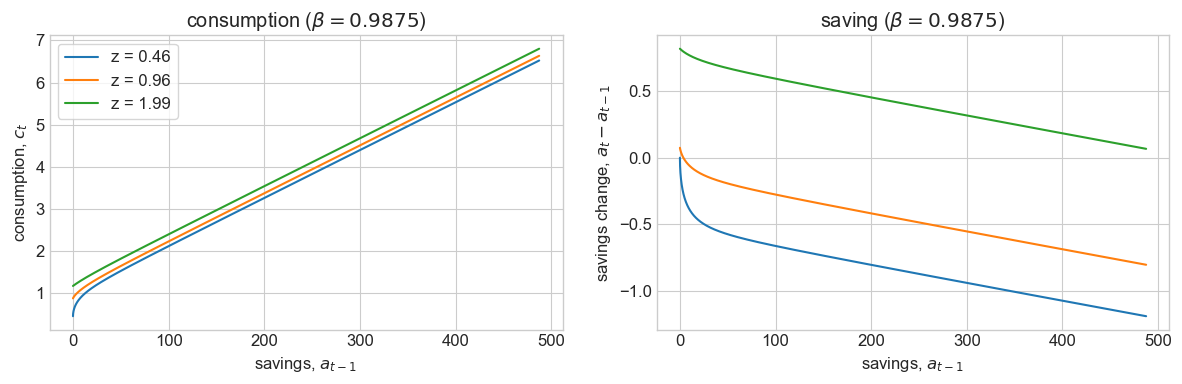

In [8]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],sol.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],sol.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

    fig.tight_layout()

## Simulation

The distribution is in `sim.D` where `sim.D.shape == [par.Nbeta,par.Nz,par.Na]`

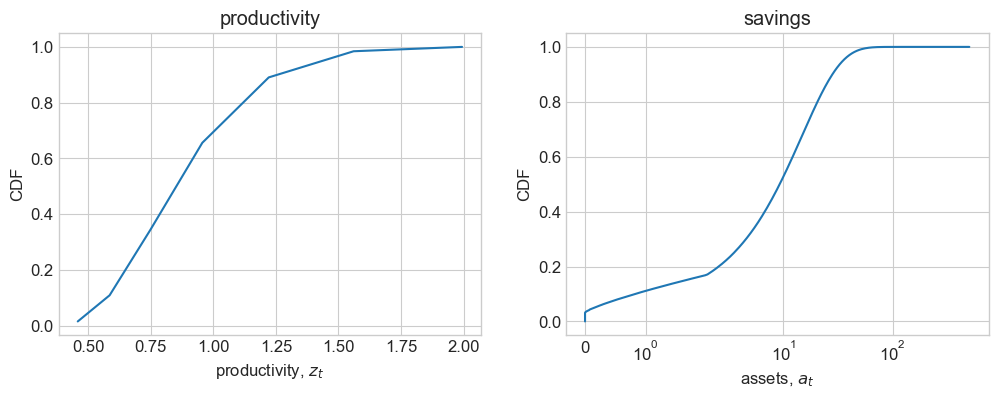

In [9]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
ax.plot(par.z_grid_ss,np.cumsum(np.sum(sim.D,axis=(0,2))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(sim.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

**Income moments:**

In [10]:
mean_z = np.sum(sim.D*par.z_grid_ss[:,np.newaxis])
std_z = np.sqrt(np.sum(sim.D*(par.z_grid_ss[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [11]:
# a. prepare
Da = np.sum(sim.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a: 12.509
p25  a:  3.545
p50  a:  9.274
p95  a: 35.143
p99  a: 50.170
std. a: 11.620


**MPC:**

In [12]:
MPC = np.zeros(sim.D.shape)
dc = (sol.c[:,:,1:]-sol.c[:,:,:-1])
dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*sim.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.044 [annual: 0.164]


# Tests

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.4 secs
household problem simulated along transition in 5.8 secs


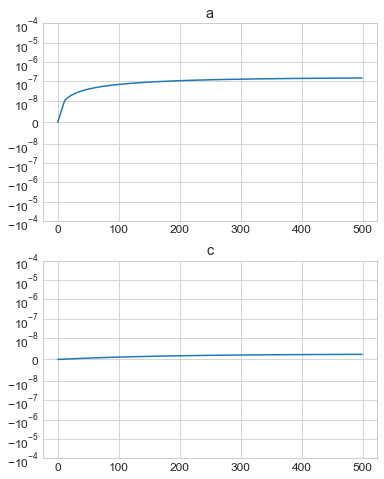

In [13]:
model.test_hh_path()

**Full transition path:**

In [14]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A_hh           : t0 =  1.8e-15, max abs.  1.5e-07
C_hh           : t0 =  0.0e+00, max abs.  2.4e-09
C              : t0 =  0.0e+00, max abs.  0.0e+00
Gamma          : t0 =  0.0e+00, max abs.  0.0e+00
K              : t0 =  0.0e+00, max abs.  0.0e+00
L              : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  1.7e-18, max abs.  1.7e-18
rk             : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0 =  0.0e+00, max abs.  0.0e+00

absolute value (potential targets):
clearing_A     : t0 = -1.8e-15, max abs.  1.5e-07
clearing_C     : t0 =  9.3e-10, max abs.  1.5e-09


**Calculation of Jacobians:**

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost: 0 50 150 250 [computed in 0.5 secs]
finding Jacobian wrt. r  : 0 50 150 250 [computed in 0.4 secs]
finding Jacobian wrt. w  : 0 50 150 250 [computed in 0.5 secs]
all Jacobians computed in 1.4 secs

fake news method:
inputname = ghost: household Jacobian computed in 4.4 secs
inputname = r: household Jacobian computed in 1.0 secs
inputname = w: household Jacobian computed in 0.9 secs
all Jacobians computed in 6.3 secs


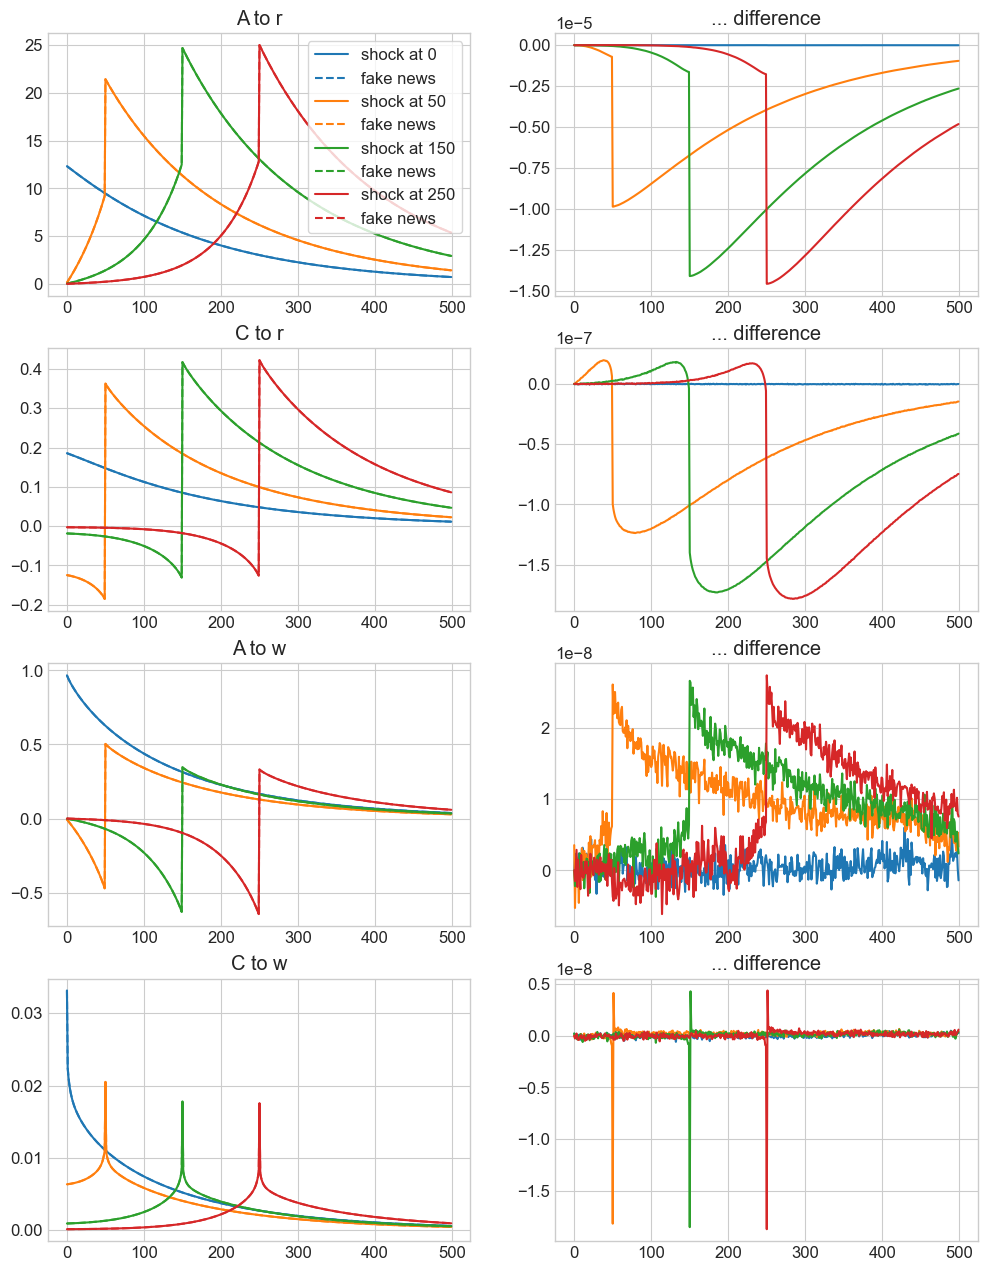

In [15]:
s_list = [0,50,150,250]
model.test_jac_hh(s_list)

# Step 2: Compute Jacobians

In [16]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
inputname = ghost: household Jacobian computed in 0.7 secs
inputname = r: household Jacobian computed in 1.2 secs
inputname = w: household Jacobian computed in 0.7 secs
all Jacobians computed in 2.7 secs

full Jacobians:
full Jacobian to unknowns computed in 0.1 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.1 secs [in evaluate_path(): 0.1 secs]


The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(outputname,inputname)`
1. **full Jacobian to *unknowns***: `model.jac_U` is a matrix
1. **full Jacobian to *shocks***: `model.jac_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

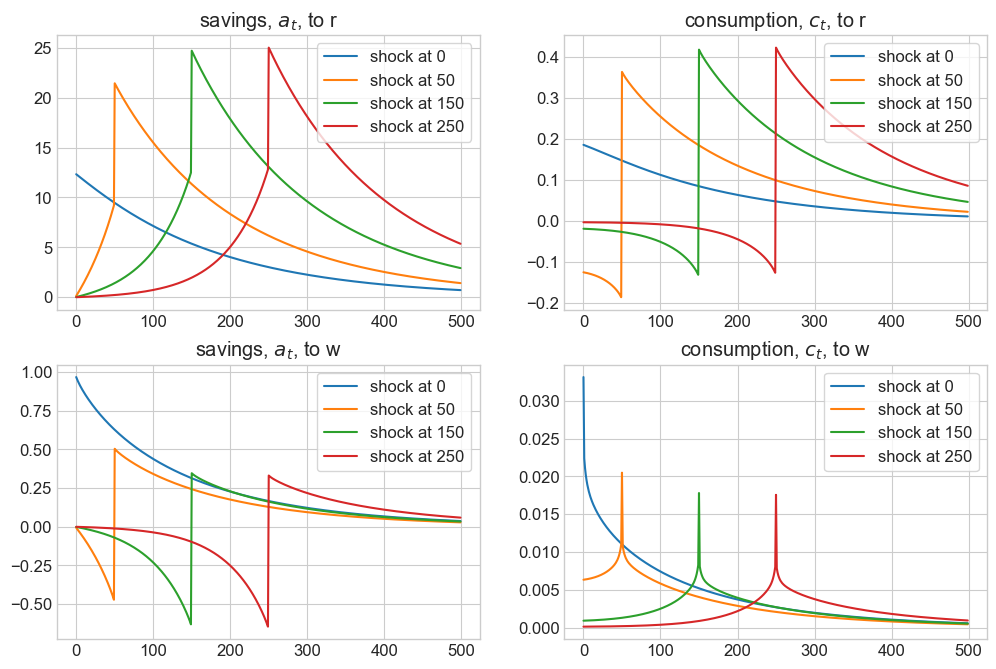

In [17]:
fig = plt.figure(figsize=(12,len(model.inputs_hh)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)
    

# Step 3a: Find non-linear transition_path

In [18]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =  1.1e-01
 it =   1 -> max. abs. error =  1.6e-04
 it =   2 -> max. abs. error =  5.0e-07
 it =   3 -> max. abs. error =  4.0e-10
 it =   4 -> max. abs. error =  4.8e-13

transition path found in 2.3 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME[0,:]`
1. The transition path of policy functions, `sol.path_a` and `sol.path_c`
1. The transition path of distributions, `sim.path_D`

The **timing** is such that `path.A[t] == np.sum(sol.path_a[t]*sim.path_D[t])`.

**Plot transitions**

### shocks ###


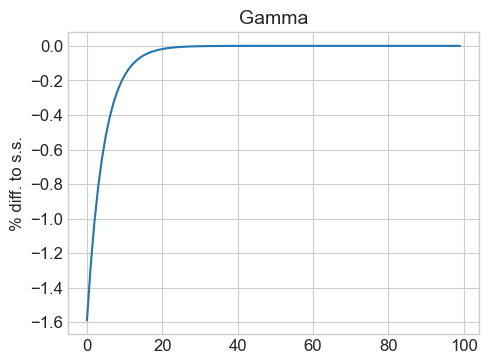


### varnames ###


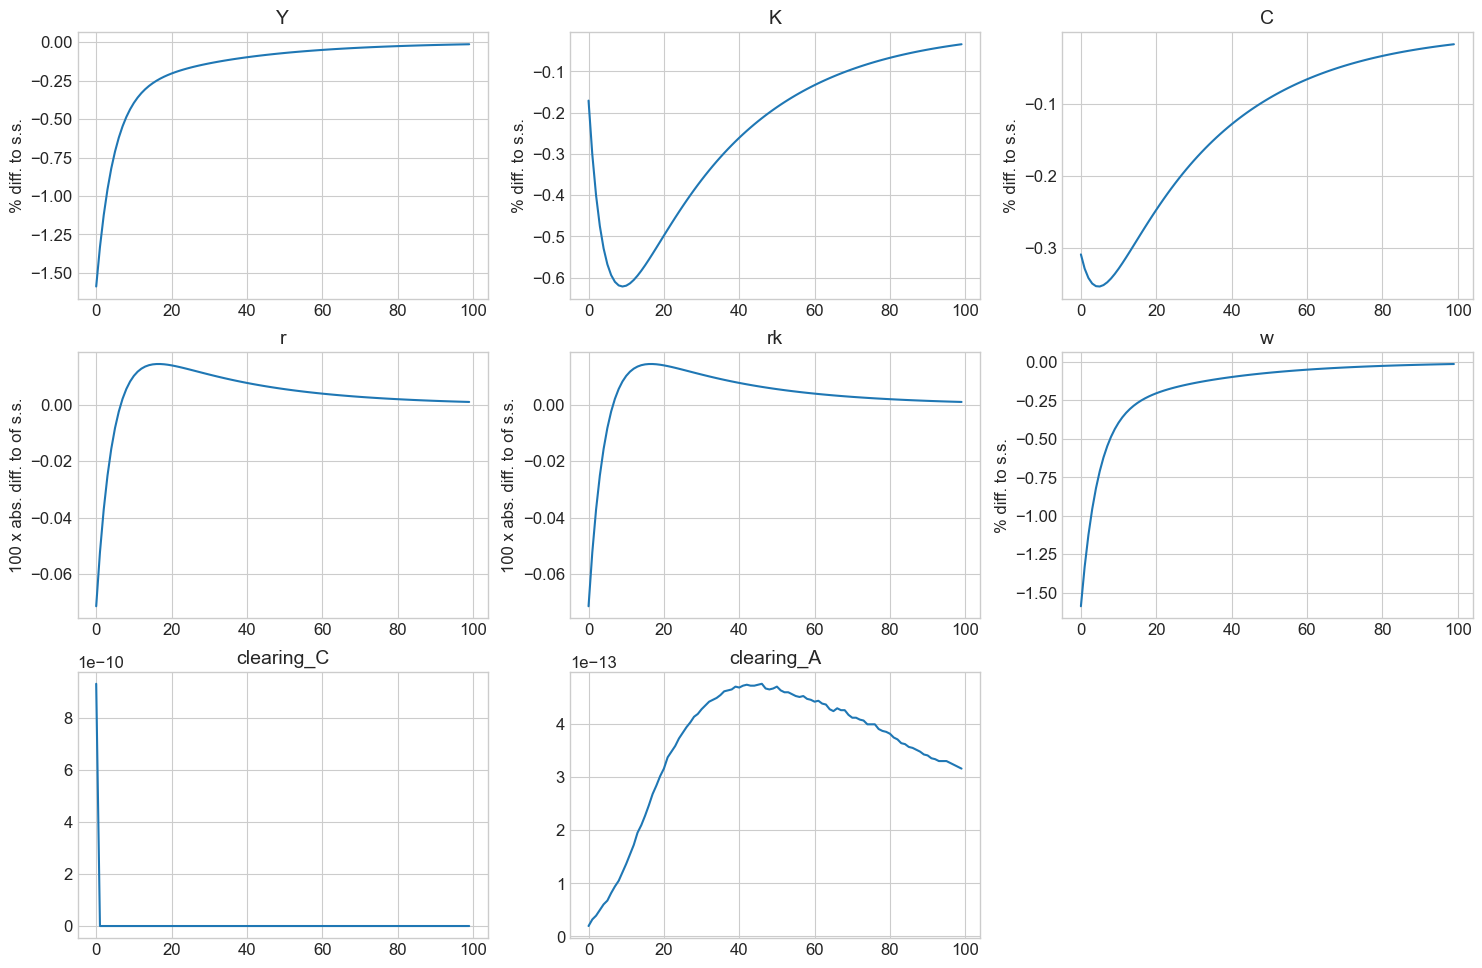


### tagets ###


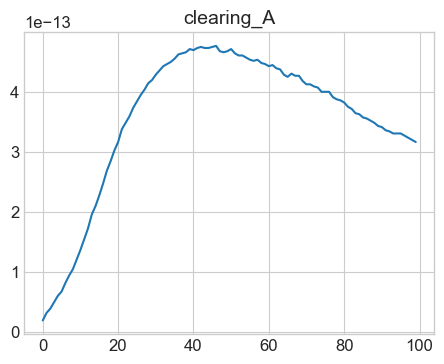

In [19]:
paths = ['Y','K','C','r','rk','w','clearing_C','clearing_A']
abs_diff = ['r','rk']
facs = {'r':100,'rk':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100)

# Step 3b: Find linearized IRFs

In [20]:
model.find_IRFs(do_print=True,reuse_G_U=False)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have `model.IRF[varname]` with the linear impulse response of all variables.

### shocks ###


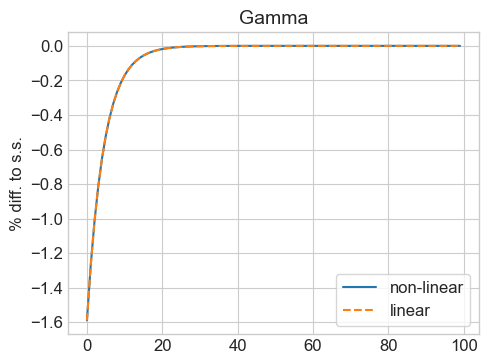


### varnames ###


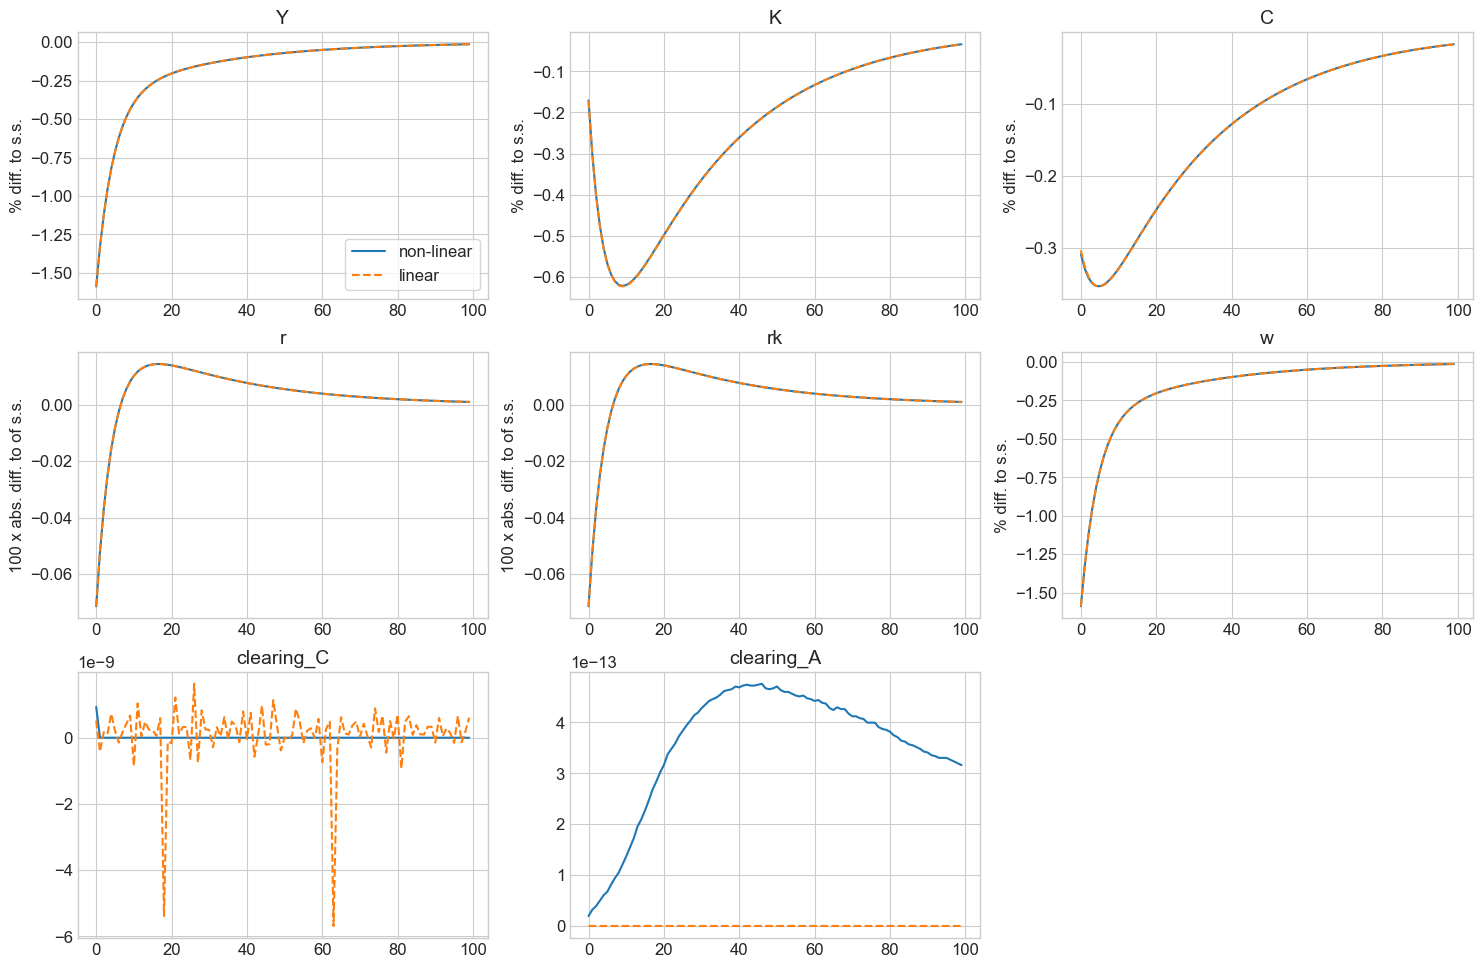


### tagets ###


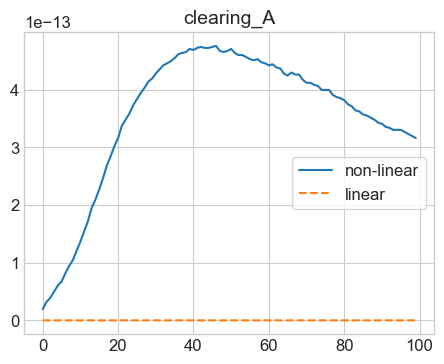

In [21]:
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,do_linear=True)

# Custom shock

### varnames ###


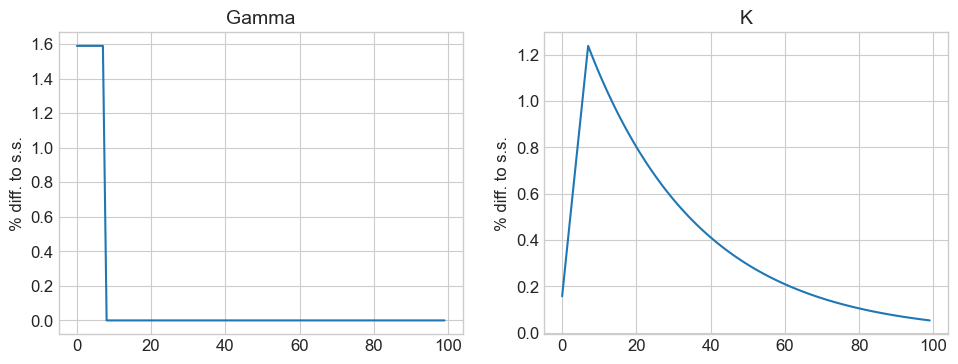

In [22]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[:8] = 0.01
shock_specs = {'dGamma':dGamma}

# b. find transition path
model.find_transition_path(shock_specs=shock_specs)
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False)

# Speed

In [23]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.5 secs [1758 iterations]
household problem in ss simulated in 1.0 secs [3052 iterations]


In [24]:
model.solve_hh_path(do_print=True)
model.simulate_hh_path(do_print=True)

household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs


In [25]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =  1.1e-01
 it =   1 -> max. abs. error =  1.6e-04
 it =   2 -> max. abs. error =  5.0e-07
 it =   3 -> max. abs. error =  4.0e-10
 it =   4 -> max. abs. error =  4.8e-13

transition path found in 2.4 secs


In [26]:
model.compute_jacs(do_print=True)

household Jacobians:
inputname = ghost: household Jacobian computed in 0.5 secs
inputname = r: household Jacobian computed in 0.7 secs
inputname = w: household Jacobian computed in 0.5 secs
all Jacobians computed in 1.6 secs

full Jacobians:
full Jacobian to unknowns computed in 0.1 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.1 secs [in evaluate_path(): 0.1 secs]


In [27]:
model.find_IRFs(do_print=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


In [28]:
model.compute_jacs(do_print=True,skip_shocks=True)

household Jacobians:
inputname = ghost: household Jacobian computed in 0.5 secs
inputname = r: household Jacobian computed in 0.6 secs
inputname = w: household Jacobian computed in 1.0 secs
all Jacobians computed in 2.2 secs

full Jacobians:
full Jacobian to unknowns computed in 0.1 secs [in evaluate_path(): 0.1 secs]


In [29]:
model.compute_jacs(do_print=True,skip_hh=True)

full Jacobians:
full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.1 secs [in evaluate_path(): 0.1 secs]


# Misc.

We can print the **unpacking code lines** typically used in the begining of `block_pre()` and `block_post()`.

In [30]:
model.print_unpack_varlist()

    for thread in nb.prange(threads):

        # unpack
        A_hh = path.A_hh[thread,:]
        C_hh = path.C_hh[thread,:]
        C = path.C[thread,:]
        clearing_A = path.clearing_A[thread,:]
        clearing_C = path.clearing_C[thread,:]
        Gamma = path.Gamma[thread,:]
        K = path.K[thread,:]
        L = path.L[thread,:]
        r = path.r[thread,:]
        rk = path.rk[thread,:]
        w = path.w[thread,:]
        Y = path.Y[thread,:]


We can update the **update aggregate settings** and automatically reallocate everything:

In [31]:
model.update_aggregate_settings(unknowns=None,shocks=None,targets=None)